# Time Series Classification
**Content:**
- Google Colab Setup
- Preprocessing
- Modeling
- Evaluation

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 9.5MB 18.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## I. Google Colab Setup

In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## II. Preprocessing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [9]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [10]:
# Drop unnecessary columns
vnq.drop(columns=['Volume', 'Dividends', 'Stock Splits', 'Ticker'], inplace=True)

In [11]:
# 
vnq['Lag 1'] = vnq['Close'].shift(periods=1)

In [12]:
# 
vnq.loc[vnq['Close'] - vnq['Lag 1'] > 0, 'Trend'] = 'up'
vnq.loc[vnq['Close'] - vnq['Lag 1'] <= 0, 'Trend'] = 'down'

In [13]:
vnq['Trend'].isna().sum()

1

In [14]:
# Drop the "Lag 1" column
vnq.drop(columns=['Lag 1'], inplace=True)

# Drop the 1st row
vnq.drop([0], inplace=True)
vnq

,Date,Open,High,Low,Close,Trend
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,up
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,up
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,up
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,down
5,2004-10-06,24.582134,24.644186,24.577361,24.644186,up
...,...,...,...,...,...,...
4208,2021-06-17,103.410004,103.699997,102.860001,103.550003,down
4209,2021-06-18,103.019997,103.470001,101.790001,101.790001,down
4210,2021-06-21,102.309998,104.209999,101.800003,103.889999,up
4211,2021-06-22,103.889999,104.010002,103.279999,103.349998,down


In [15]:
# Set the "Date" column as the index 
ut.preprocess_df(vnq)

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2004-09-30,23.866143,24.023660,23.861370,23.985474,up
2004-10-01,24.033207,24.462799,23.985476,24.429386,up
2004-10-04,24.529629,24.606000,24.529629,24.534403,up
2004-10-05,24.534403,24.582135,24.510535,24.529629,down
2004-10-06,24.582134,24.644186,24.577361,24.644186,up
...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,down
2021-06-18,103.019997,103.470001,101.790001,101.790001,down
2021-06-21,102.309998,104.209999,101.800003,103.889999,up


In [16]:
vnq['Trend'].unique()

array(['up', 'down'], dtype=object)

In [17]:
vnq['Trend'].value_counts()

up      2264
down    1948
Name: Trend, dtype: int64

In [18]:
# Label encoding
label_encoder = LabelEncoder()
vnq['Trend']= label_encoder.fit_transform(vnq['Trend'])

In [19]:
vnq['Trend'].value_counts()

1    2264
0    1948
Name: Trend, dtype: int64

In [20]:
# Split the data into train, validation, and test set
# Test size = 1 month (21 days)
# Val size = 1 year (252 days)
# Train size = rest of the time
train = vnq.iloc[:-252]
test = vnq.iloc[-252:]

In [21]:
def xy_split(dataset):
    '''
    Split the dataset into X-part and y-part.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input:
    - dataset: dataframe

    Return:
    - X, y
    
    '''

    X = dataset.drop(columns=['Trend'], axis=1)
    y = dataset['Trend']

    return X, y

In [22]:
X_train, y_train = xy_split(train)
X_test, y_test = xy_split(test)

### Pipeline

In [23]:
num_cols = vnq.columns[:-1].tolist()
num_cols

['Open', 'High', 'Low', 'Close']

In [24]:
# Set up scaling step
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])  

# Put scaling step into a Column Transformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols)])

## III. Modeling

### Baseline Model

Train
-*-*-*-*-*-*-*-*
accuracy: 0.5439
roc-auc: 0.7166 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.5714
roc-auc: 0.8819


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.57      1.00      0.73       144

    accuracy                           0.57       252
   macro avg       0.29      0.50      0.36       252
weighted avg       0.33      0.57      0.42       252



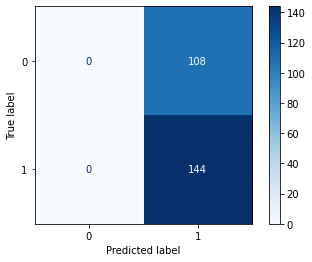

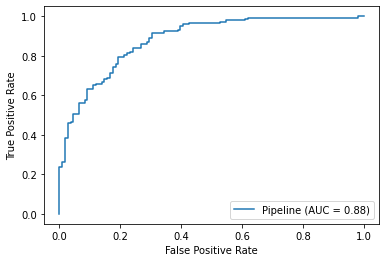

([0.5439], [0.5714], [0.7166], [0.8819])

In [25]:
# Logistic Regression
lg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(random_state=24))])

lg_clf.fit(X_train, y_train)

lg_result = ut.evaluate_classification(lg_clf, X_train, y_train, X_test, y_test, use_decision_function='yes')
lg_result

>**Comment:** *Logistic Regression*
- Bad performance: unable to detect the decrease pattern

### KNN

Train
-*-*-*-*-*-*-*-*
accuracy: 0.8889
roc-auc: 0.9539 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.7421
roc-auc: 0.8156


              precision    recall  f1-score   support

           0       0.77      0.56      0.65       108
           1       0.73      0.88      0.79       144

    accuracy                           0.74       252
   macro avg       0.75      0.72      0.72       252
weighted avg       0.75      0.74      0.73       252



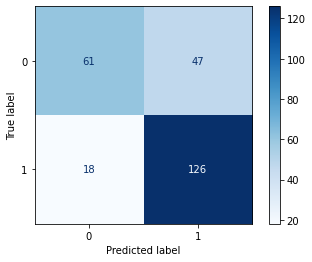

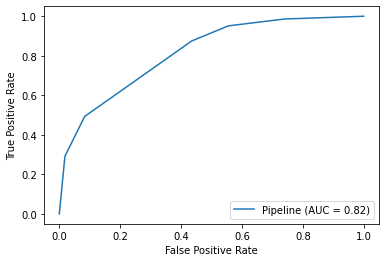

([0.8889], [0.7421], [0.9539], [0.8156])

In [26]:
knn_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', KNeighborsClassifier())])

knn_clf.fit(X_train, y_train)

knn_result = ut.evaluate_classification(knn_clf, X_train, y_train, X_test, y_test, use_decision_function='no')
knn_result

>**Comment:** *KNN*
- slightly overfit

### Tree

#### Random Forest

Train
-*-*-*-*-*-*-*-*
accuracy: 1.0000
roc-auc: 1.0000 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.7024
roc-auc: 0.7929


              precision    recall  f1-score   support

           0       0.62      0.77      0.69       108
           1       0.79      0.65      0.71       144

    accuracy                           0.70       252
   macro avg       0.71      0.71      0.70       252
weighted avg       0.72      0.70      0.70       252



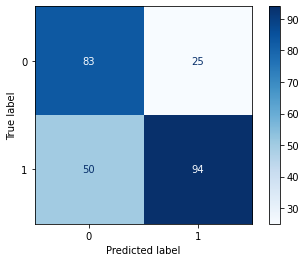

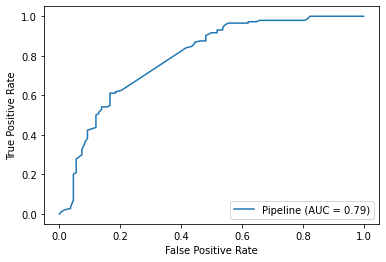

([1.0], [0.7024], [1.0], [0.7929])

In [27]:
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(criterion='entropy', random_state=24))])

rf_clf.fit(X_train, y_train)

rf_result = ut.evaluate_classification(rf_clf, X_train, y_train, X_test, y_test, use_decision_function='no')
rf_result

>**Comment:** *Random Forest*
- super overfit

#### Bagging

Train
-*-*-*-*-*-*-*-*
accuracy: 0.9866
roc-auc: 0.9991 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.6825
roc-auc: 0.7542


              precision    recall  f1-score   support

           0       0.60      0.77      0.67       108
           1       0.78      0.62      0.69       144

    accuracy                           0.68       252
   macro avg       0.69      0.69      0.68       252
weighted avg       0.70      0.68      0.68       252



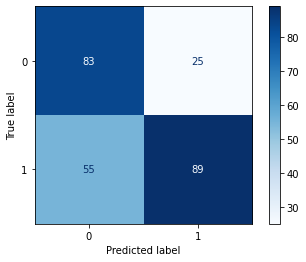

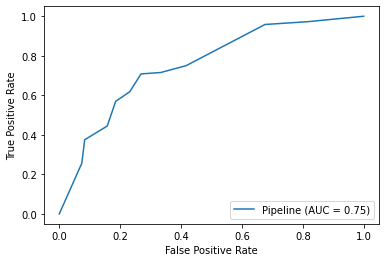

([0.9866], [0.6825], [0.9991], [0.7542])

In [28]:
bag_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=24)))])

bag_clf.fit(X_train, y_train)

bag_result = ut.evaluate_classification(bag_clf, X_train, y_train, X_test, y_test, use_decision_function='no')
bag_result

>**Comment:** *Bagging*
- super overfit

### Boost

#### XGBoost

Train
-*-*-*-*-*-*-*-*
accuracy: 0.7563
roc-auc: 0.8651 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.5794
roc-auc: 0.5841


              precision    recall  f1-score   support

           0       0.56      0.09      0.16       108
           1       0.58      0.94      0.72       144

    accuracy                           0.58       252
   macro avg       0.57      0.52      0.44       252
weighted avg       0.57      0.58      0.48       252



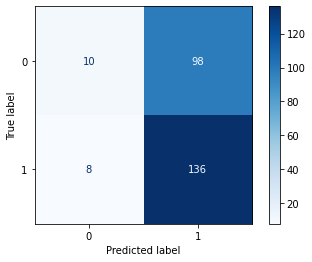

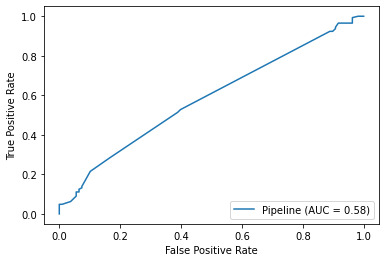

([0.7563], [0.5794], [0.8651], [0.5841])

In [29]:
xgb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(random_state=24))])

xgb_clf.fit(X_train, y_train)

xgb_result = ut.evaluate_classification(xgb_clf, X_train, y_train, X_test, y_test, use_decision_function='no')
xgb_result

>**Comment:** *XGBoost*
- slightly overfit
- poor performance on detecting decrease trend

#### AdaBoost

Train
-*-*-*-*-*-*-*-*
accuracy: 1.0000
roc-auc: 1.0000 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.6984
roc-auc: 0.7118


              precision    recall  f1-score   support

           0       0.61      0.81      0.70       108
           1       0.81      0.62      0.70       144

    accuracy                           0.70       252
   macro avg       0.71      0.71      0.70       252
weighted avg       0.72      0.70      0.70       252



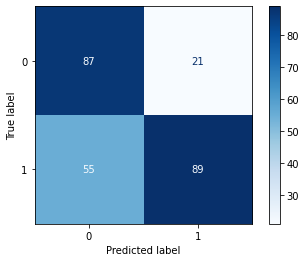

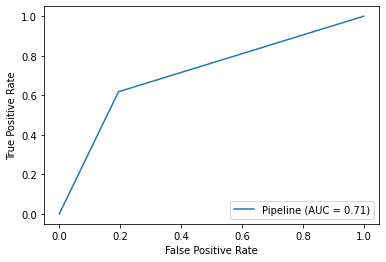

([1.0], [0.6984], [1.0], [0.7118])

In [30]:
ada_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', random_state=24)))])

ada_clf.fit(X_train, y_train)

ada_result = ut.evaluate_classification(ada_clf, X_train, y_train, X_test, y_test, use_decision_function='no')
ada_result

>**Comment:** *AdaBoost*
- super overfit

#### Gradient Boosting

Train
-*-*-*-*-*-*-*-*
accuracy: 0.7672
roc-auc: 0.8746 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.5595
roc-auc: 0.5834


              precision    recall  f1-score   support

           0       0.48      0.29      0.36       108
           1       0.59      0.76      0.66       144

    accuracy                           0.56       252
   macro avg       0.53      0.53      0.51       252
weighted avg       0.54      0.56      0.53       252



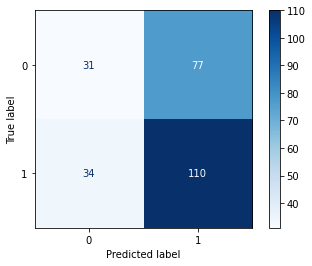

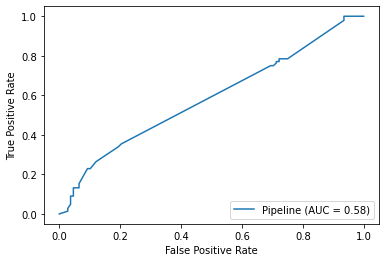

([0.7672], [0.5595], [0.8746], [0.5834])

In [31]:
gb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=24))])

gb_clf.fit(X_train, y_train)

gb_result = ut.evaluate_classification(gb_clf, X_train, y_train, X_test, y_test, use_decision_function='no')
gb_result

>**Comment:** *Gradient Boost*
- slightly overfit

### SVM

#### SVC

Train
-*-*-*-*-*-*-*-*
accuracy: 0.7760
roc-auc: 0.9085 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.8730
roc-auc: 0.9383


              precision    recall  f1-score   support

           0       0.82      0.90      0.86       108
           1       0.92      0.85      0.88       144

    accuracy                           0.87       252
   macro avg       0.87      0.88      0.87       252
weighted avg       0.88      0.87      0.87       252



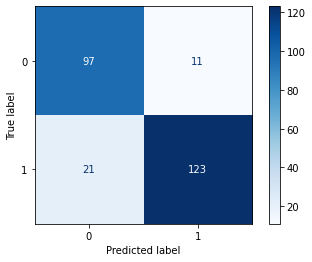

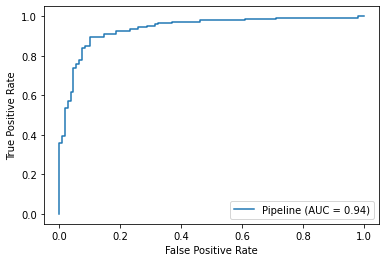

([0.776], [0.873], [0.9085], [0.9383])

In [32]:
svc_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', SVC(kernel='poly', random_state=24))])

svc_clf.fit(X_train, y_train)

svc_result = ut.evaluate_classification(svc_clf, X_train, y_train, X_test, y_test, use_decision_function='yes')
svc_result

#### NuSVC

Train
-*-*-*-*-*-*-*-*
accuracy: 0.8106
roc-auc: 0.9140 

Test
-*-*-*-*-*-*-*-*
accuracy: 0.8849
roc-auc: 0.9366


              precision    recall  f1-score   support

           0       0.84      0.90      0.87       108
           1       0.92      0.88      0.90       144

    accuracy                           0.88       252
   macro avg       0.88      0.89      0.88       252
weighted avg       0.89      0.88      0.89       252



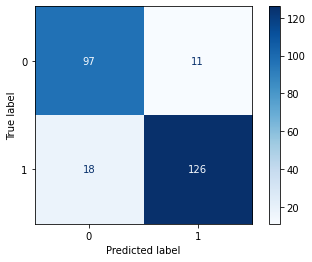

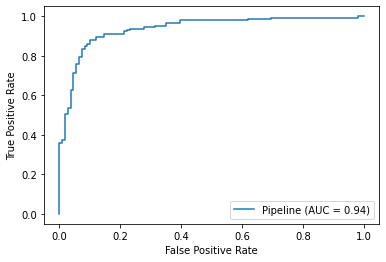

([0.8106], [0.8849], [0.914], [0.9366])

In [33]:
# 
nusvc_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', NuSVC(kernel='poly', random_state=24))])

nusvc_clf.fit(X_train, y_train)

nusvc_result = ut.evaluate_classification(nusvc_clf, X_train, y_train, X_test, y_test, use_decision_function='yes')
nusvc_result

## IV. Evaluation

In [34]:
# Put all models' evaluation results in a list
model_results = [lg_result,
                 knn_result,
                 rf_result,
                 bag_result,
                 xgb_result,
                 ada_result,
                 gb_result,
                 svc_result,
                 nusvc_result]

In [35]:
df = ut.model_comparison(model_results)
df

,classifier,train_acc,test_acc,acc_diff,train_roc_auc,test_roc_auc,roc_auc_diff
0,Logistic Regression,0.5439,0.5714,0.0275,0.7166,0.8819,0.1653
1,KNN,0.8889,0.7421,0.1468,0.9539,0.8156,0.1383
2,Random Forest,1,0.7024,0.2976,1,0.7929,0.2071
3,Bagging,0.9866,0.6825,0.3041,0.9991,0.7542,0.2449
4,XGBoost,0.7563,0.5794,0.1769,0.8651,0.5841,0.281
5,AdaBoost,1,0.6984,0.3016,1,0.7118,0.2882
6,GradientBoost,0.7672,0.5595,0.2077,0.8746,0.5834,0.2912
7,SVC,0.776,0.873,0.097,0.9085,0.9383,0.0298
8,NuSVC,0.8106,0.8849,0.0743,0.914,0.9366,0.0226


In [36]:
df['test_acc'].max()

0.8849

### Tuning Hyperparameter

In [223]:
# Odd numbers from 1 to 25
# n = list(range(1, 27, 2))
# param_grid = {'classifier__n_neighbors': n}

# Grid search for k
# search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='f1')
# search.fit(X_train, y_train)

# print(f"Best parameter: {search.best_params_}\n")

# Evaluate the model with best k
# evaluate_classification(search.best_estimator_, X_train, y_train, X_test, y_test)

In [224]:
# Odd numbers from 1 to 25
# n = [0,1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# p_grid = {'classifier__nu': n}

# Grid search for k
# search = GridSearchCV(nusvc_clf, p_grid, cv=5, scoring='f1')
# search.fit(X_train, y_train)

# print(f"Best parameter: {search.best_params_}\n")

# Evaluate the model with best k
# evaluate_classification(search.best_estimator_, X_train, y_train, X_test, y_test)

In [225]:
# Odd numbers from 1 to 25
# n = [0.1, 1, 10, 100, 1000]
# p_grid = {'classifier__C': n}

# Grid search for k
# search = GridSearchCV(svc_clf, p_grid, cv=5, scoring='f1')
# search.fit(X_train, y_train)

# print(f"Best parameter: {search.best_params_}\n")

# Evaluate the model with best k
# evaluate_classification(search.best_estimator_, X_train, y_train, X_test, y_test)